<a href="https://colab.research.google.com/github/Yandres25/Es_o_no_es_Perro_Caliente/blob/main/Notebooks/Es_o_no_es_perro_caliente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importar Librerias

In [1]:
### Importar Librerías

import torch
from torchvision.datasets import Food101
from torchvision import transforms, models
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

### Configuracion Inicial

In [2]:
### Configuración inicial
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Fijar semillas para reproducibilidad
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


Usando dispositivo: cuda


### Transformaciones

Se implementarán dos transformaciones, primero de forma base normalizada y segundo aplicando Data Augmentation, con técnicas como redimensionamiento, recortes aleatorios, volteo horizontal, rotación, ajuste de color y RandomErasing.

In [3]:
# Transformación base (sin data augmentation)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Transformación con data augmentation para entrenamiento
augment_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])


### Cargar Datasets Base
Cargamos el dataset Food101 para entrenamiento y prueba. Luego, identificamos los índices correspondientes a la clase 'hot_dog' y las demás clases para preparar nuestros datasets binarios.

In [4]:
### Cargar datasets base

# Dataset para visualización
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

print("Cargando datasets...")
train_dataset = Food101(root='.', download=True, split='train', transform=viz_transform)
test_dataset = Food101(root='.', download=True, split='test', transform=viz_transform)

# Obtener índices de hot dogs
hot_dog_index = train_dataset.classes.index('hot_dog')
print(f"Índice de 'hot_dog': {hot_dog_index}")

# Obtener todos los índices
targets = train_dataset._labels
hotdog_indices = [i for i, label in enumerate(targets) if label == hot_dog_index]
not_hotdog_indices = [i for i, label in enumerate(targets) if label != hot_dog_index]

test_targets = test_dataset._labels
test_hotdog_indices = [i for i, label in enumerate(test_targets) if label == hot_dog_index]
test_not_hotdog_indices = [i for i, label in enumerate(test_targets) if label != hot_dog_index]

print(f"\nDatos disponibles:")
print(f"Train - Hot dogs: {len(hotdog_indices)}, No hot dogs: {len(not_hotdog_indices)}")
print(f"Test - Hot dogs: {len(test_hotdog_indices)}, No hot dogs: {len(test_not_hotdog_indices)}")


Cargando datasets...


100%|██████████| 5.00G/5.00G [04:04<00:00, 20.4MB/s]


Índice de 'hot_dog': 55

Datos disponibles:
Train - Hot dogs: 750, No hot dogs: 75000
Test - Hot dogs: 250, No hot dogs: 25000


###Dataset Binario
Se utilizará para manejar el subconjunto de datos y las etiquetas binarias  (hot dog vs. no hot dog).

In [5]:
class BinaryFoodDataset(Dataset):
    def __init__(self, original_dataset, indices, labels, transform=None):
        self.original_dataset = original_dataset
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]

        # Obtener imagen PIL del dataset original
        image, _ = self.original_dataset[original_idx]

        # Convertir tensor a PIL si es necesario
        if torch.is_tensor(image):
            # Convertir de tensor a PIL
            image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)
        else:
            image = base_transform(image)

        label = torch.tensor([self.labels[idx]], dtype=torch.float32)
        return image, label


### Repetición de Dataset para Dara Augmentation
Se utilizará para balancear el tamaño del dataset en la clase pequeña (Hot Dog), en el experimento de Data Augmentation (10000 datos)

In [6]:
"""### Dataset con repetición para data augmentation"""

class AugmentedHotdogDataset(Dataset):
    def __init__(self, original_dataset, hotdog_indices, target_size, transform):
        self.original_dataset = original_dataset
        self.hotdog_indices = hotdog_indices
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return self.target_size

    def __getitem__(self, idx):
        # Elegir un hot dog al azar
        original_idx = random.choice(self.hotdog_indices)
        image, _ = self.original_dataset[original_idx]

        # Convertir tensor a PIL si es necesario
        if torch.is_tensor(image):
            image = transforms.ToPILImage()(image)

        image = self.transform(image)
        label = torch.tensor([1.0], dtype=torch.float32)
        return image, label


### Preparación Dataset de Test

In [7]:
# Balancear test set
random.seed(42)
test_balanced_not_hotdog = random.sample(test_not_hotdog_indices, len(test_hotdog_indices))
test_all_indices = test_hotdog_indices + test_balanced_not_hotdog
test_labels = [1.0] * len(test_hotdog_indices) + [0.0] * len(test_balanced_not_hotdog)

test_binary_ds = BinaryFoodDataset(
    test_dataset,
    test_all_indices,
    test_labels,
    transform=base_transform
)

test_loader = DataLoader(test_binary_ds, batch_size=32, shuffle=False, num_workers=2)
print(f"\nTest set: {len(test_binary_ds)} muestras ({len(test_hotdog_indices)} hot dogs, {len(test_balanced_not_hotdog)} no hot dogs)")



Test set: 500 muestras (250 hot dogs, 250 no hot dogs)


# Modelado de Red Neuronal Convolucional
Definición de la arquitectura de la CNN efectiva para clasificación binaria.

In [8]:
class CNNBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.classifier(self.features(x))


### Función de Entrenamiento
Función para entrenar con el bucle de entrenamiento y evaluación.

In [9]:
def train_model(model, train_loader, test_loader, model_name, n_epochs=5):
    print(f"\n{'='*50}")
    print(f"ENTRENANDO: {model_name}")
    print(f"{'='*50}")

    # Limpiar memoria GPU antes de cada entrenamiento
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Reinicializar completamente el modelo
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    best_test_acc = 0.0
    results = []

    start_time = time.time()

    for epoch in range(n_epochs):
        # ——————— ENTRENAMIENTO ———————
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = total_loss / total_train
        train_acc = 100.0 * correct_train / total_train

        # ——————— EVALUACIÓN ———————
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = (outputs > 0.5).float()
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_acc = 100.0 * correct_test / total_test

        if test_acc > best_test_acc:
            best_test_acc = test_acc

        results.append({
            'epoch': epoch + 1,
            'train_loss': avg_loss,
            'train_acc': train_acc,
            'test_acc': test_acc
        })

        print(f'Epoch {epoch+1}/{n_epochs}: Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    training_time = time.time() - start_time
    print(f"\nTiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"Mejor Test Accuracy: {best_test_acc:.2f}%")

    return model, results, best_test_acc


### Función de Evaluación Detallada
Se evaluarán métricas de rendimiento más detalladas como precisión, recall, F1-score, y los verdaderos/falsos positivos/negativos.

In [10]:
def evaluate_detailed(model, test_loader, model_name):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())

    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probabilities = np.array(all_probabilities).flatten()

    # Calcular métricas
    tp = np.sum((all_predictions == 1) & (all_labels == 1))
    tn = np.sum((all_predictions == 0) & (all_labels == 0))
    fp = np.sum((all_predictions == 1) & (all_labels == 0))
    fn = np.sum((all_predictions == 0) & (all_labels == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{model_name} - Resultados detallados:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }


### Visualización de imagenes Aleatorios Food-101


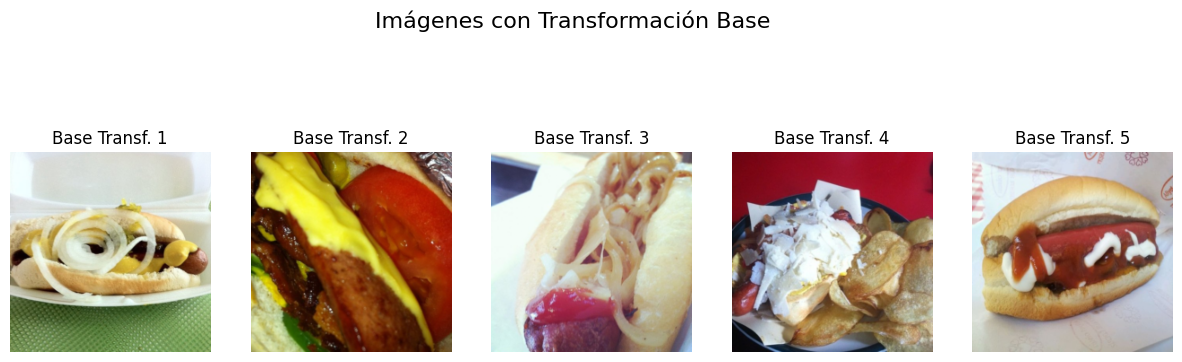

In [12]:
import matplotlib.pyplot as plt
import random
import torch
from torchvision import transforms # Asegúrate de importar transforms

# Asumiendo que las siguientes variables ya están definidas desde tu código inicial:
# train_dataset (Food101 cargado con viz_transform, lo que hace que sus elementos sean tensores)
# hotdog_indices
# base_transform

def visualize_base_transformation_samples(dataset, indices, transform, num_images=3):
    plt.figure(figsize=(15, 5))
    plt.suptitle('Imágenes con Transformación Base', fontsize=16)
    for i in range(num_images):
        index = random.choice(indices)
        # Aquí, image_tensor es ya un tensor debido a viz_transform en la carga del dataset
        image_tensor, _ = dataset[index]

        # *** CORRECCIÓN CLAVE: Convertir el tensor de nuevo a PIL Image ***
        # Las transformaciones 'base_transform' esperan una imagen PIL o NumPy array
        image_pil = transforms.ToPILImage()(image_tensor)

        # Aplicar la transformación base (ahora recibirá una imagen PIL)
        transformed_image = transform(image_pil)

        # Desnormalizar la imagen para la visualización
        # Asegúrate de que estos valores de mean y std coincidan con los usados en base_transform
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        transformed_image_display = transformed_image * std + mean

        # Asegurarse de que los valores de píxeles estén en el rango [0, 1] para imshow
        transformed_image_display = torch.clamp(transformed_image_display, 0, 1)

        # Convertir a formato NumPy para Matplotlib
        transformed_image_display = transformed_image_display.permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(transformed_image_display)
        plt.title(f'Base Transf. {i+1}')
        plt.axis('off')
    plt.show()

# Llama a la función para visualizar
visualize_base_transformation_samples(train_dataset, hotdog_indices, base_transform, num_images=5)

### Visualización de imágenes de Food-101 con Data Augmentation

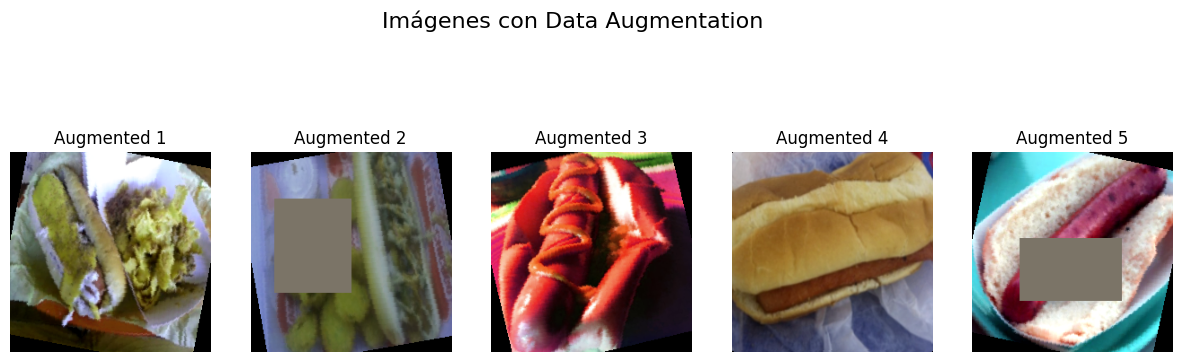

In [13]:
import matplotlib.pyplot as plt
import random
import torch
from torchvision import transforms # Asegúrate de importar transforms

# Asumiendo que las siguientes variables ya están definidas desde tu código inicial:
# train_dataset (Food101 cargado con viz_transform, lo que hace que sus elementos sean tensores)
# hotdog_indices
# augment_transform

def visualize_augment_transformation_samples(dataset, indices, transform, num_images=3):
    plt.figure(figsize=(15, 5))
    plt.suptitle('Imágenes con Data Augmentation', fontsize=16)
    for i in range(num_images):
        index = random.choice(indices)
        # Aquí, image_tensor es ya un tensor debido a viz_transform en la carga del dataset
        image_tensor, _ = dataset[index]

        # *** CORRECCIÓN CLAVE: Convertir el tensor de nuevo a PIL Image ***
        # Las transformaciones 'augment_transform' esperan una imagen PIL o NumPy array
        image_pil = transforms.ToPILImage()(image_tensor)

        # Aplicar la transformación con data augmentation (ahora recibirá una imagen PIL)
        augmented_image = transform(image_pil)

        # Desnormalizar la imagen para la visualización
        # Asegúrate de que estos valores de mean y std coincidan con los usados en augment_transform
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        augmented_image_display = augmented_image * std + mean

        # Asegurarse de que los valores de píxeles estén en el rango [0, 1] para imshow
        augmented_image_display = torch.clamp(augmented_image_display, 0, 1)

        # Convertir a formato NumPy para Matplotlib
        augmented_image_display = augmented_image_display.permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(augmented_image_display)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    plt.show()

# Llama a la función para visualizar
visualize_augment_transformation_samples(train_dataset, hotdog_indices, augment_transform, num_images=5)

# Prueba 1: Balanceo Básico (750 muestras cada  clase)
Teniendo en cuenta que el Dataset Food-101 tiene 1000 imágenes de cada clase, entonces para el objetivo "Hot Dog", solo hay 1000 imagenes, estas se dividen en 750 para el train y 250 para el test. Para la otra clasificación tambien se usarán 750 imágenes de otros alimentos para mantener el balance.

In [14]:
def experiment_1():
    print(f"\n🔥 EXPERIMENTO 1: BALANCEO BÁSICO (750 + 750)")

    # Limpiar memoria antes del experimento
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Usar solo 750 hot dogs - nueva semilla para este experimento
    random.seed(42)
    torch.manual_seed(42)

    selected_hotdog_indices = random.sample(hotdog_indices, 750)
    selected_not_hotdog_indices = random.sample(not_hotdog_indices, 750)

    # Crear dataset
    train_indices = selected_hotdog_indices + selected_not_hotdog_indices
    train_labels = [1.0] * 750 + [0.0] * 750

    train_ds = BinaryFoodDataset(
        train_dataset,
        train_indices,
        train_labels,
        transform=base_transform
    )

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

    print(f"Dataset de entrenamiento: {len(train_ds)} muestras")

    # Crear NUEVO modelo CNN desde cero
    model1 = CNNBinary()
    print("Modelo CNN creado desde cero para Prueba 1")

    model1, results, best_acc = train_model(model1, train_loader, test_loader, "CNN con Balanceo Básico", n_epochs=15)

    # Limpiar después del entrenamiento
    del train_loader, train_ds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return model1, results, best_acc

# Prueba 2: Data Augmentation (10,000 muestras para cada clase)
Se aplicó data augmentation en las 750 imágenes de hot dog hasta tener un total de 10000, y así entrenarse con otras 10000 imagenes de otros alimentos.

In [15]:
def experiment_2():
    print(f"\n🚀 EXPERIMENTO 2: DATA AUGMENTATION (10,000 + 10,000)")

    # Limpiar memoria antes del experimento
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Reinicializar semillas para este experimento
    random.seed(123)  # Diferente semilla
    torch.manual_seed(123)

    # Dataset aumentado de hot dogs
    hotdog_augmented_ds = AugmentedHotdogDataset(
        train_dataset,
        hotdog_indices,
        target_size=10000,
        transform=augment_transform
    )

    # Dataset de no-hot-dogs (10,000 muestras)
    selected_not_hotdog_indices = random.sample(not_hotdog_indices, 10000)
    not_hotdog_labels = [0.0] * 10000

    not_hotdog_ds = BinaryFoodDataset(
        train_dataset,
        selected_not_hotdog_indices,
        not_hotdog_labels,
        transform=augment_transform
    )

    # Combinar datasets
    combined_ds = ConcatDataset([hotdog_augmented_ds, not_hotdog_ds])
    train_loader = DataLoader(combined_ds, batch_size=32, shuffle=True, num_workers=2)

    print(f"Dataset de entrenamiento: {len(combined_ds)} muestras")

    # Crear NUEVO modelo CNN desde cero
    model2 = CNNBinary()
    print("Modelo CNN creado desde cero para Prueba 2")

    model2, results, best_acc = train_model(model2, train_loader, test_loader, "CNN con Data Augmentation", n_epochs=7)

    # Limpiar después del entrenamiento
    del train_loader, combined_ds, hotdog_augmented_ds, not_hotdog_ds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return model2, results, best_acc


#Prueba 3: Utilizando preentrenamiento ResNet18

In [16]:
def experiment_3():
    print(f"\n🎯 EXPERIMENTO 3: RESNET18 PREENTRENADO (10,000 + 10,000)")

    # Limpiar memoria antes del experimento
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Reinicializar semillas para este experimento
    random.seed(456)  # Diferente semilla
    torch.manual_seed(456)

    # Dataset aumentado de hot dogs
    hotdog_augmented_ds = AugmentedHotdogDataset(
        train_dataset,
        hotdog_indices,
        target_size=10000,
        transform=augment_transform
    )

    selected_not_hotdog_indices = random.sample(not_hotdog_indices, 10000)
    not_hotdog_labels = [0.0] * 10000

    not_hotdog_ds = BinaryFoodDataset(
        train_dataset,
        selected_not_hotdog_indices,
        not_hotdog_labels,
        transform=augment_transform
    )

    combined_ds = ConcatDataset([hotdog_augmented_ds, not_hotdog_ds])
    train_loader = DataLoader(combined_ds, batch_size=32, shuffle=True, num_workers=2)

    print(f"Dataset de entrenamiento: {len(combined_ds)} muestras")

    # Crear NUEVO modelo ResNet18 desde cero
    model3 = models.resnet18(pretrained=True)
    print("Modelo ResNet18 cargado NUEVO desde pretrained para Prueba 3")

    # Fine-tuning: descongelar últimas capas
    for param in model3.parameters():
        param.requires_grad = False

    # Descongelar las últimas capas
    for param in model3.layer4.parameters():
        param.requires_grad = True
    for param in model3.avgpool.parameters():
        param.requires_grad = True

    # Reemplazar la última capa
    num_features = model3.fc.in_features
    model3.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 1),
        nn.Sigmoid()
    )

    model3, results, best_acc = train_model(model3, train_loader, test_loader, "ResNet18 Preentrenado", n_epochs=7)

    # Limpiar después del entrenamiento
    del train_loader, combined_ds, hotdog_augmented_ds, not_hotdog_ds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return model3, results, best_acc


#Llamado a las Pruebas

In [17]:
def run_all_experiments():
    results_summary = []

    print("🔥🚀🎯 INICIANDO LOS 3 EXPERIMENTOS 🎯🚀🔥")
    print("="*60)

    # Experimento 1
    model1, results1, best_acc1 = experiment_1()
    detailed1 = evaluate_detailed(model1, test_loader, "Prueba 1")
    results_summary.append(("Balanceo Básico (750+750)", best_acc1, detailed1))

    # Experimento 2
    model2, results2, best_acc2 = experiment_2()
    detailed2 = evaluate_detailed(model2, test_loader, "Prueba 2")
    results_summary.append(("Data Augmentation (10k+10k)", best_acc2, detailed2))

    # Experimento 3
    model3, results3, best_acc3 = experiment_3()
    detailed3 = evaluate_detailed(model3, test_loader, "Prueba 3")
    results_summary.append(("ResNet18 Preentrenado (10k+10k)", best_acc3, detailed3))

    # Resumen final
    print(f"\n{'='*60}")
    print("RESUMEN FINAL DE TODAS LAS PRUEBAS")
    print(f"{'='*60}")

    for i, (name, best_acc, detailed) in enumerate(results_summary, 1):
        print(f"\n{i}. {name}:")
        print(f"   Mejor Test Accuracy: {best_acc:.2f}%")
        print(f"   Precision: {detailed['precision']:.3f}")
        print(f"   Recall: {detailed['recall']:.3f}")
        print(f"   F1-Score: {detailed['f1']:.3f}")

    # Encontrar el mejor
    best_experiment = max(results_summary, key=lambda x: x[1])
    print(f"\nEl Mejor: {best_experiment[0]} con {best_experiment[1]:.2f}% de accuracy")

    return results_summary


In [18]:
## Ejecutar todos las pruebas

if __name__ == "__main__":
    results = run_all_experiments()

🔥🚀🎯 INICIANDO LOS 3 EXPERIMENTOS 🎯🚀🔥

🔥 EXPERIMENTO 1: BALANCEO BÁSICO (750 + 750)
Dataset de entrenamiento: 1500 muestras
Modelo CNN creado desde cero para Prueba 1

ENTRENANDO: CNN con Balanceo Básico
Epoch 1/15: Loss: 0.6937, Train Acc: 52.80%, Test Acc: 59.60%
Epoch 2/15: Loss: 0.6625, Train Acc: 61.40%, Test Acc: 59.00%
Epoch 3/15: Loss: 0.6374, Train Acc: 64.80%, Test Acc: 60.80%
Epoch 4/15: Loss: 0.6155, Train Acc: 66.13%, Test Acc: 62.20%
Epoch 5/15: Loss: 0.5950, Train Acc: 67.93%, Test Acc: 63.40%
Epoch 6/15: Loss: 0.5733, Train Acc: 71.53%, Test Acc: 62.20%
Epoch 7/15: Loss: 0.5355, Train Acc: 74.60%, Test Acc: 63.40%
Epoch 8/15: Loss: 0.5124, Train Acc: 75.80%, Test Acc: 63.80%
Epoch 9/15: Loss: 0.4756, Train Acc: 78.33%, Test Acc: 62.80%
Epoch 10/15: Loss: 0.4435, Train Acc: 79.60%, Test Acc: 63.40%
Epoch 11/15: Loss: 0.4164, Train Acc: 81.93%, Test Acc: 63.80%
Epoch 12/15: Loss: 0.3817, Train Acc: 84.27%, Test Acc: 62.20%
Epoch 13/15: Loss: 0.3462, Train Acc: 87.47%, Test

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


Modelo ResNet18 cargado NUEVO desde pretrained para Prueba 3

ENTRENANDO: ResNet18 Preentrenado
Epoch 1/7: Loss: 0.6796, Train Acc: 59.60%, Test Acc: 65.00%
Epoch 2/7: Loss: 0.6307, Train Acc: 64.63%, Test Acc: 71.40%
Epoch 3/7: Loss: 0.6057, Train Acc: 67.23%, Test Acc: 72.60%
Epoch 4/7: Loss: 0.5918, Train Acc: 68.41%, Test Acc: 74.00%
Epoch 5/7: Loss: 0.5766, Train Acc: 69.55%, Test Acc: 73.00%
Epoch 6/7: Loss: 0.5675, Train Acc: 70.45%, Test Acc: 72.20%
Epoch 7/7: Loss: 0.5579, Train Acc: 71.38%, Test Acc: 74.40%

Tiempo de entrenamiento: 1738.83 segundos
Mejor Test Accuracy: 74.40%

Prueba 3 - Resultados detallados:
Accuracy: 74.40%
Precision: 0.814
Recall: 0.632
F1-Score: 0.712
TP: 158, TN: 214, FP: 36, FN: 92

RESUMEN FINAL DE TODAS LAS PRUEBAS

1. Balanceo Básico (750+750):
   Mejor Test Accuracy: 63.80%
   Precision: 0.603
   Recall: 0.620
   F1-Score: 0.611

2. Data Augmentation (10k+10k):
   Mejor Test Accuracy: 76.20%
   Precision: 0.854
   Recall: 0.608
   F1-Score: 0.710
